In [1]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [3]:
class Faces(Dataset):
    
    def __init__(self, path, transforms):
        self.transforms = transforms
        self.path = path
        self.images = [name for name in os.listdir(self.path)]
        self.images = self.images[:20000]
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.path + "/" + self.images[idx]))

In [4]:
transforms = T.Compose([T.Resize(128), T.ToTensor()])
dataset = Faces('/kaggle/input/flickrfaceshq-dataset-ffhq', transforms)

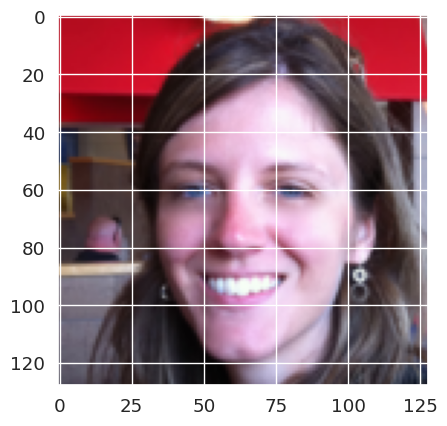

In [5]:
plt.imshow(dataset[126].permute(1, 2, 0))

In [6]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
# discriminator = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
#                              nn.MaxPool2d(2, 2), nn.BatchNorm2d(64), nn.ReLU(True), # 3 128 128 -> 64 64 64
#                              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#                              nn.MaxPool2d(2, 2), nn.BatchNorm2d(128), nn.ReLU(True), # 64 64 64 -> 128 32 32
#                              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#                              nn.MaxPool2d(2, 2), nn.BatchNorm2d(256), nn.ReLU(True), # 128 32 32 -> 256 16 16
#                              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
#                              nn.MaxPool2d(2, 2), nn.BatchNorm2d(512), nn.ReLU(True), # 256 16 16 -> 512 8 8 
#                              nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
#                              nn.MaxPool2d(2, 2), nn.BatchNorm2d(1024), nn.ReLU(True), # 512 8 8 -> 1024 4 4
#                              nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
#                              nn.MaxPool2d(2, 2), nn.BatchNorm2d(1024), nn.ReLU(True), # 1024 4 4 -> 1024 2 2
#                              nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=3, padding=1),
#                              nn.MaxPool2d(2, 2), nn.BatchNorm2d(1), nn.ReLU(True), # 1024 2 2 -> 1 1 1
#                              nn.Flatten(), nn.Sigmoid())

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [9]:
latent_size = 16
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    
    # 3 x 128 x 128
    
)

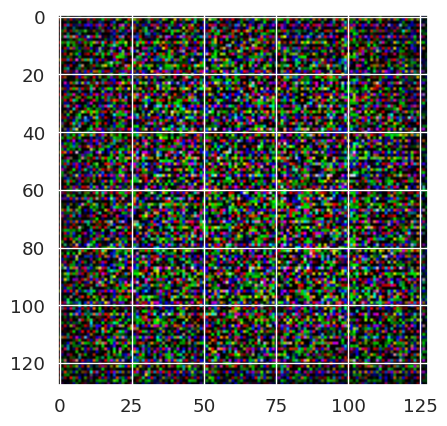

In [10]:
xb = torch.randn(1, latent_size, 1, 1) 
fake_images = generator(xb)
plt.imshow(fake_images.detach()[0].permute(1, 2, 0))

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
discriminator.to(device)
generator.to(device)

Sequential(
  (0): ConvTranspose2d(16, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [12]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}



In [13]:
model['discriminator'].load_state_dict(torch.load('/kaggle/input/gan-weights/discriminator.pth'))
model['generator'].load_state_dict(torch.load('/kaggle/input/gan-weights/generator.pth'))

<All keys matched successfully>

In [14]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(dataloader):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()
            real_images = real_images.to(device)
            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)
        fake_images = model["generator"](fixed_latent)
        plt.imshow(fake_images[0].detach().cpu().permute(1, 2, 0))
        plt.show() 
        # Save generated images
#         if epoch == epochs - 1:
#             save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 7.9208, loss_d: 0.2283, real_score: 0.9433, fake_score: 0.0631


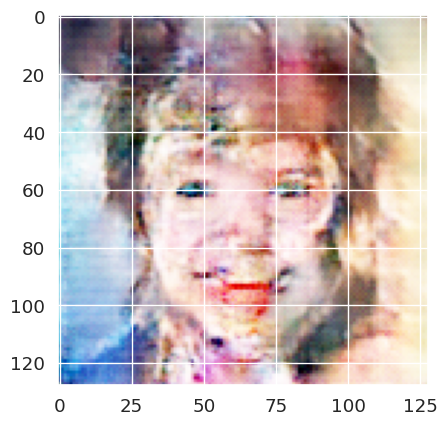

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 6.5097, loss_d: 0.1830, real_score: 0.9399, fake_score: 0.0535


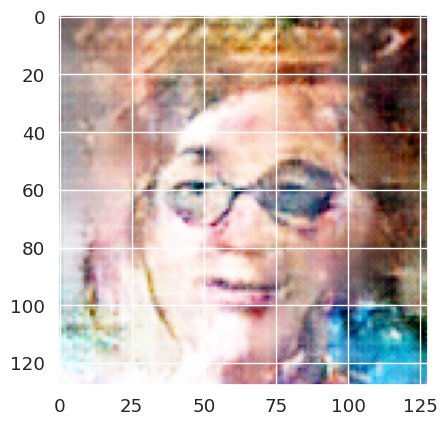

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 7.2615, loss_d: 0.1839, real_score: 0.9433, fake_score: 0.0575


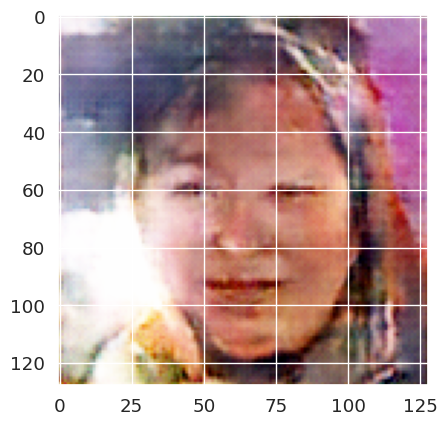

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 7.4292, loss_d: 0.2448, real_score: 0.9350, fake_score: 0.0638


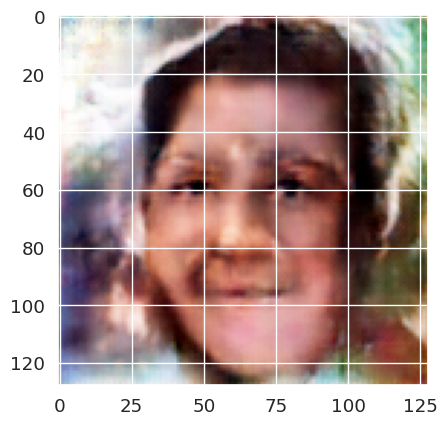

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 7.5426, loss_d: 0.2027, real_score: 0.9337, fake_score: 0.0660


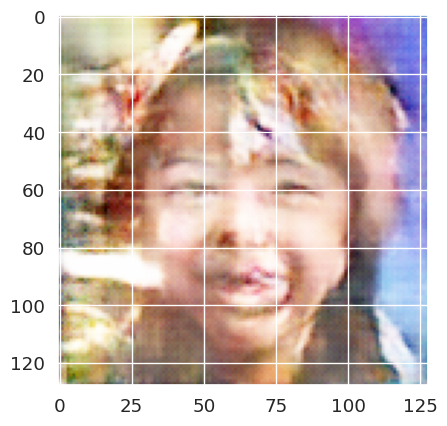

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 8.2333, loss_d: 0.2732, real_score: 0.9315, fake_score: 0.0702


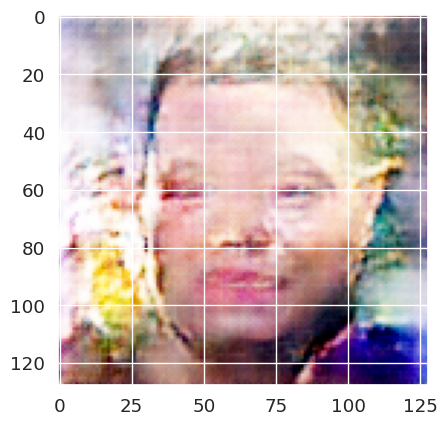

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 6.6248, loss_d: 0.1626, real_score: 0.9395, fake_score: 0.0569


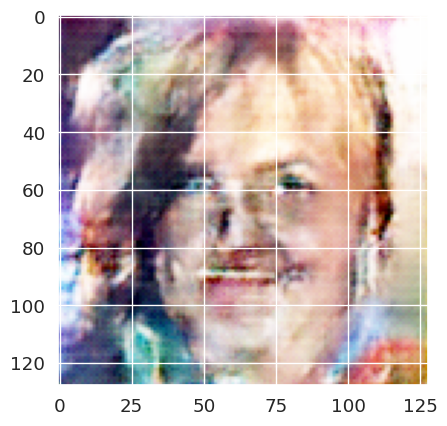

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 6.9234, loss_d: 0.1980, real_score: 0.9379, fake_score: 0.0620


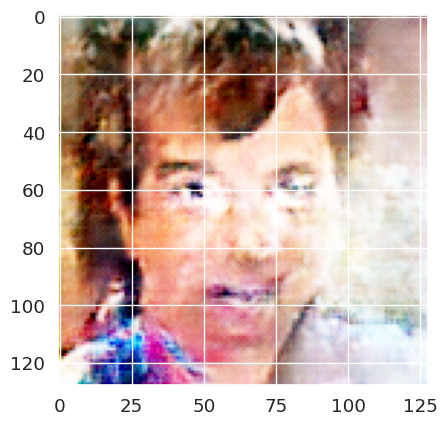

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 7.9813, loss_d: 0.2063, real_score: 0.9351, fake_score: 0.0626


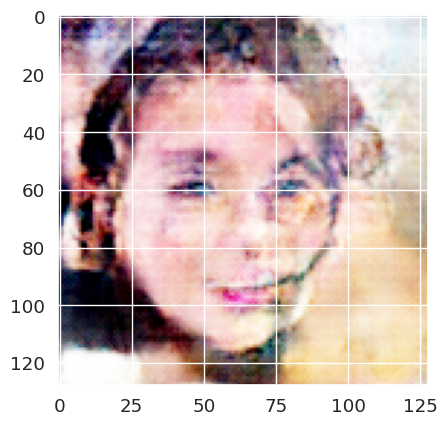

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 6.7850, loss_d: 0.1533, real_score: 0.9464, fake_score: 0.0549


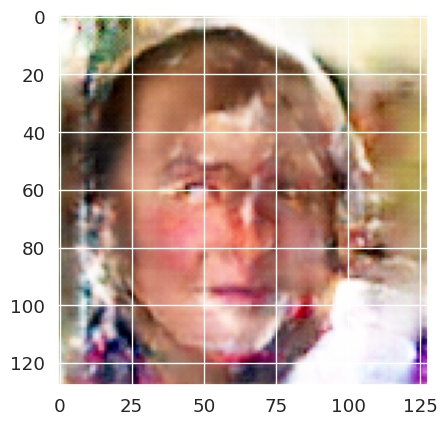

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 7.3161, loss_d: 0.1821, real_score: 0.9434, fake_score: 0.0556


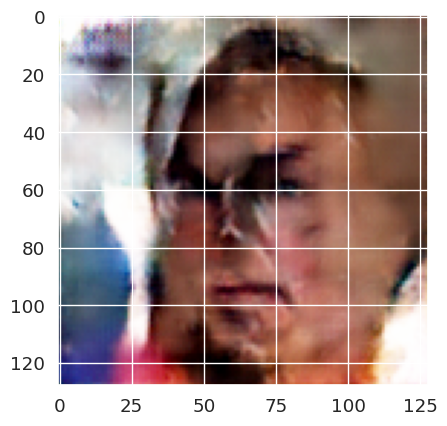

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 7.6322, loss_d: 0.1711, real_score: 0.9412, fake_score: 0.0564


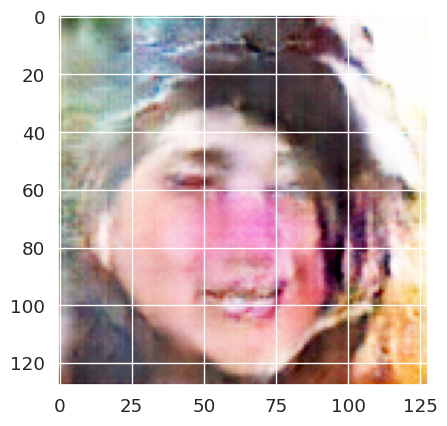

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 7.3520, loss_d: 0.2215, real_score: 0.9383, fake_score: 0.0624


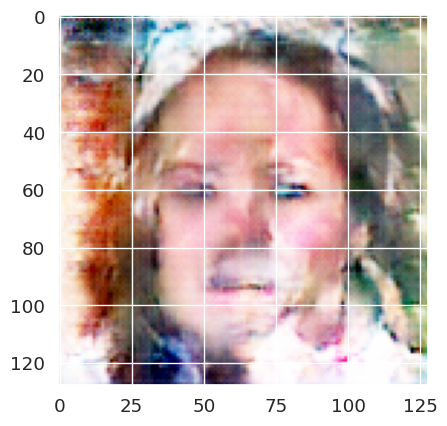

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 7.7825, loss_d: 0.1668, real_score: 0.9443, fake_score: 0.0541


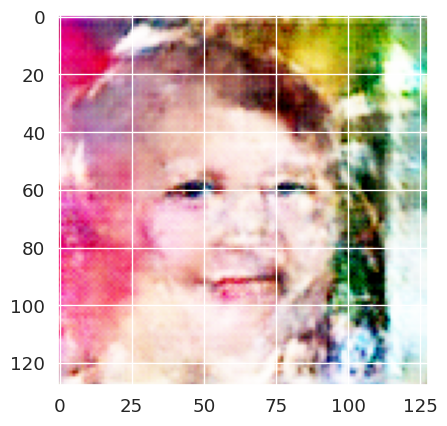

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 7.4004, loss_d: 0.1419, real_score: 0.9491, fake_score: 0.0506


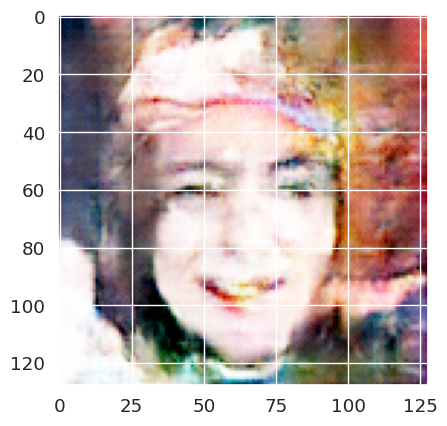

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 7.5710, loss_d: 0.2078, real_score: 0.9429, fake_score: 0.0565


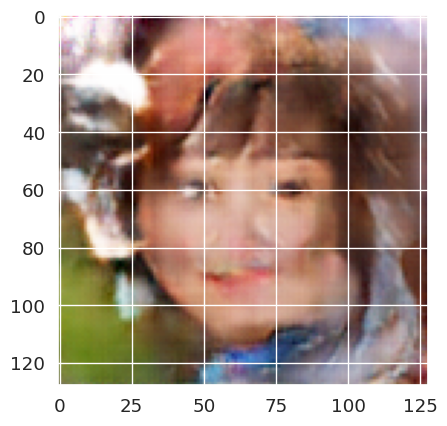

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 6.9526, loss_d: 0.1777, real_score: 0.9456, fake_score: 0.0530


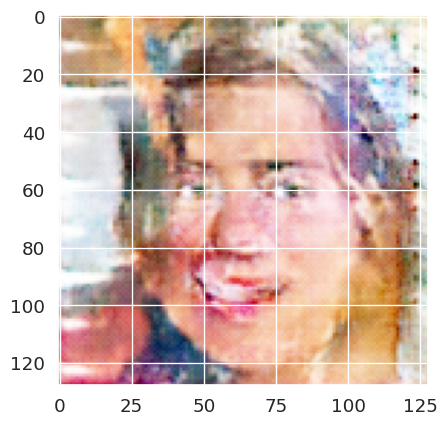

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 7.3041, loss_d: 0.1565, real_score: 0.9494, fake_score: 0.0500


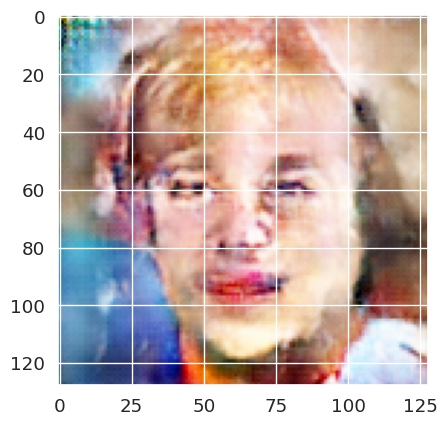

  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
epochs = 40
history = fit(model, criterion, epochs, lr)

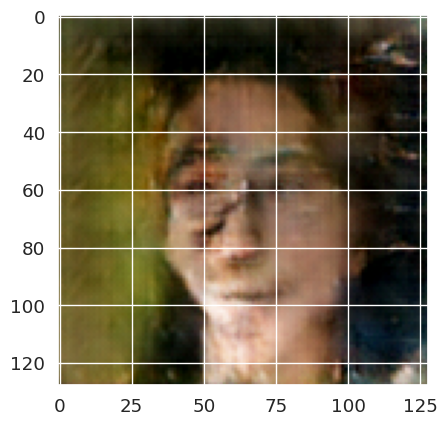

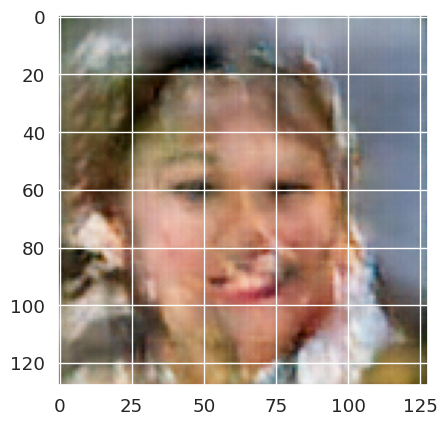

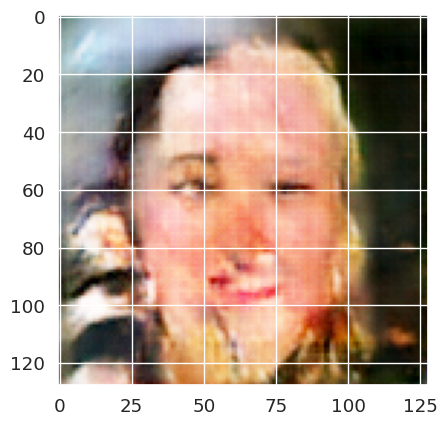

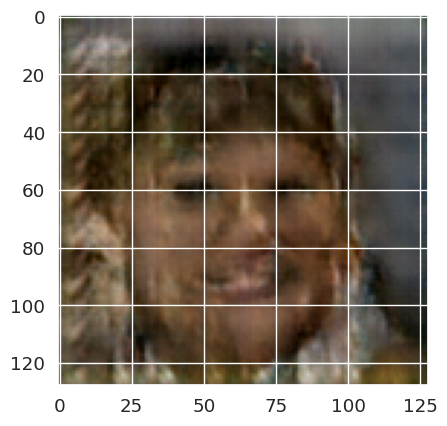

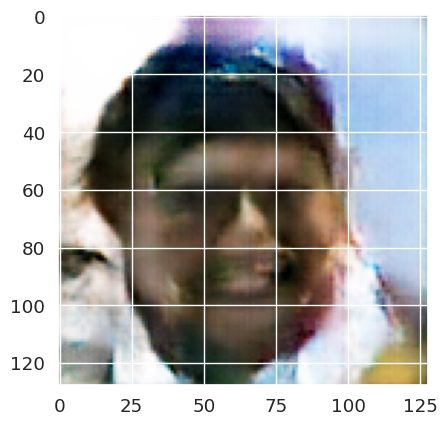

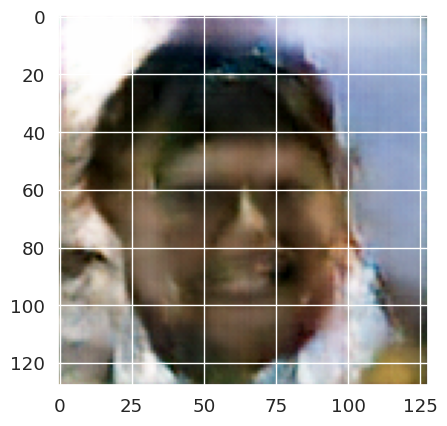

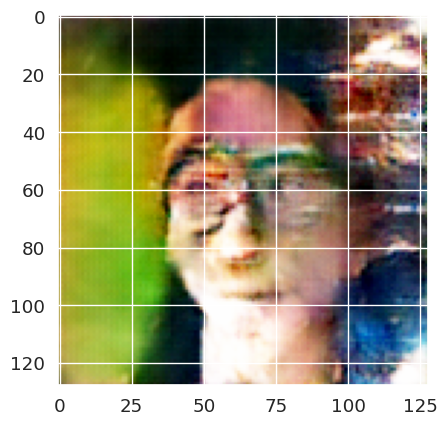

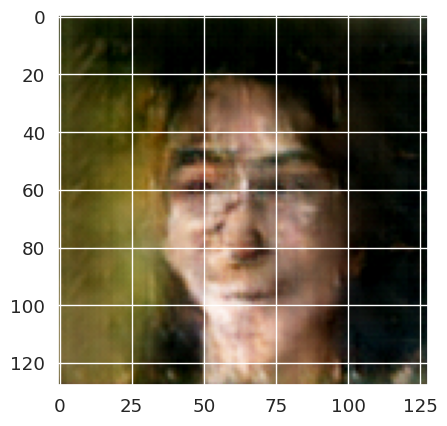

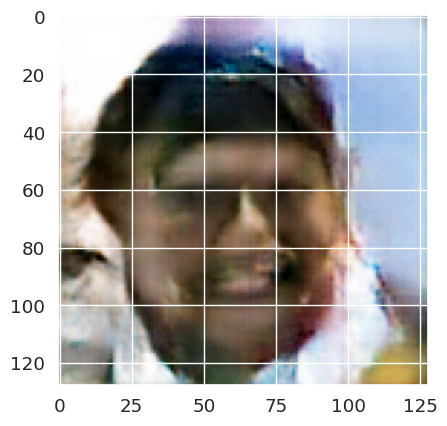

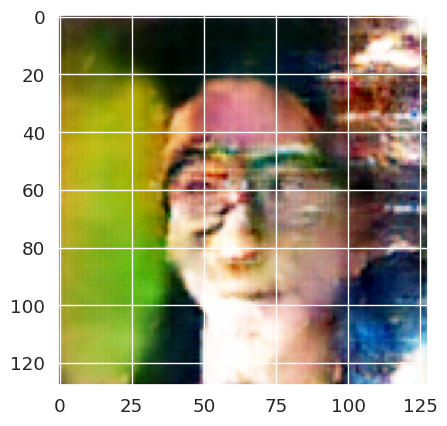

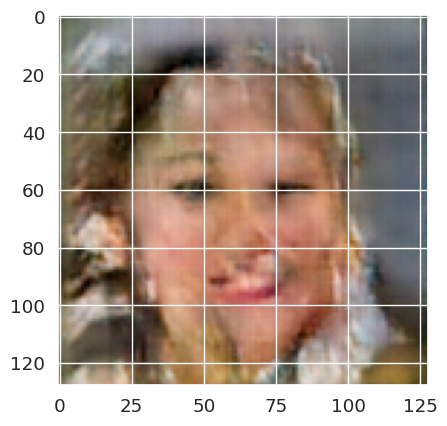

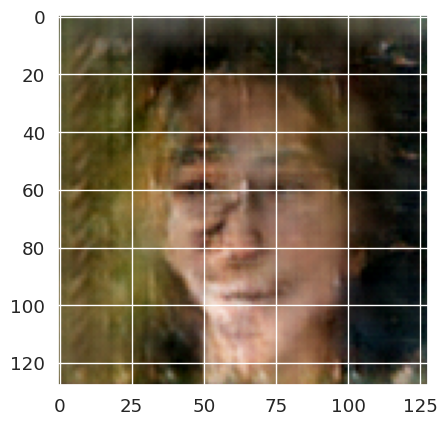

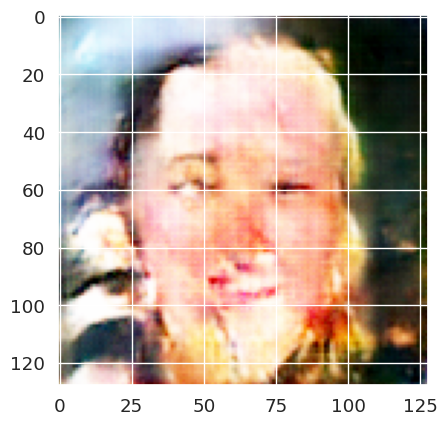

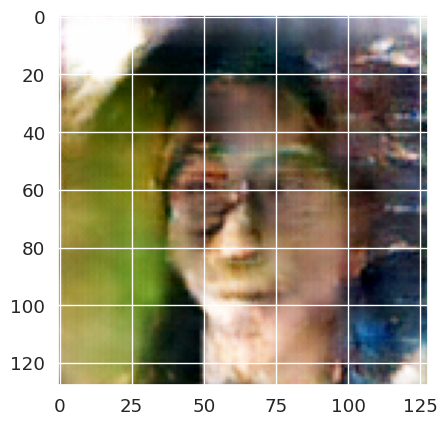

In [16]:
n_images = 14

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
for i in range(n_images):
    plt.imshow(fake_images[i].detach().cpu().permute(1, 2, 0))
    plt.show()

In [17]:
torch.save(model['generator'].state_dict(), 'generator.pth')
torch.save(model['discriminator'].state_dict(), 'discriminator.pth')